# Task
The red globs are chromosomes inside nuclei, the green dots are double strand breaks.  Your goal is to count the number of double strand breaks per nucleus under these treatment conditions.

+ Choose 5 nuclei from the control worm and 5 nuclei from the experimental worm.
+ Count the number of bright green puncta in each nucleus.
+ Report the mean and standard deviation of the number of puncta per chromosome between your 5 control and 5 experimental chromosomes.  
+ Are the differences you observed statistically significant? (A t-test seems like a reasonable way to go about this...)

### Hints:

+ Define a circular mask for each nucleus you want to study.
+ The *same* puncta can occur across multiple slices, but not all puncta appear in all slices.  (This is a 3D chromosome blob).  You'll have to make sure you don't count the same point twice.  

### Data
The collection of images are available here:

https://www.dropbox.com/s/dry59l6h14cqkkj/worm-images.zip?dl=0

If you unzip the directory, it has the following files and directories.

+ worm-images
    + experimental
        + z000.png
        + z001.png
        + ...
        + z066.png
    + control
        + z011.png
        + z012.png
        + ...
        + z054.png
        
+ Each `zxxx.png` file is a slice.  
+ The R, G, and B channels have different information:
    + R: chromosome marker
    + G: double-strand break marker
    + B: nucleus marker

## Importing, opening, and saving all the images in dictionaries 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile

from skimage.feature import blob_dog, blob_log, blob_doh # SHIFT + TAB
from skimage.color import rgb2gray
from skimage.draw import circle

import os
import glob

In [2]:
# Import the names of all images of type *.png using recursive glob function
experimental = []
control = []
for image in glob.glob("**\control\*.png", recursive = True):
    control.append(image)
for image in glob.glob("**\experimental\*.png", recursive = True):
    experimental.append(image)

# Convert the list of names to tuples for faster processing
experimental = tuple(experimental)
control = tuple(control)

# Storing all image data as arrays into a dictionary with keys by number
exp_dict = {}
for counter, image in enumerate(experimental):
    exp_dict.setdefault(counter, np.array(Image.open(image)))
control_dict = {}
for counter, image in enumerate(control):
    control_dict.setdefault(counter, np.array(Image.open(image)))

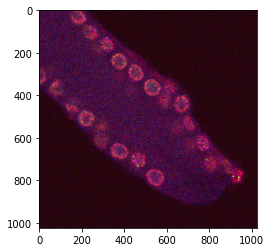

In [3]:
# An example of how to access the image data from the dictionaries
plt.imshow(exp_dict.get(1))

Plotting on a grid for fun

In [4]:
# Uncomment to plot all experimental images on a grid. It's not necessary, I did just for fun

# fig = plt.figure(figsize=(18, 18))
# rows = int(len(experimental)/10)+1
# columns = 10

# print(f"Your grid will have {rows} rows and {columns} columns")

# for counter,image in enumerate(experimental):
#     fig.add_subplot(rows, columns, counter+1)
#     plt.imshow(exp_dict.get(counter))

# plt.show()

In [5]:
# Uncomment to plot all control images on a grid. It's not necessary, I did just for fun

# fig = plt.figure(figsize=(18, 18))
# rows = int(len(control)/10)+1
# columns = 10

# print(f"Your grid will have {rows} rows and {columns} columns")

# for counter,image in enumerate(control):
#     fig.add_subplot(rows, columns, counter+1)
#     plt.imshow(control_dict.get(counter))

# plt.show()

## Identifying blobs in a sample image using difference of Gaussians

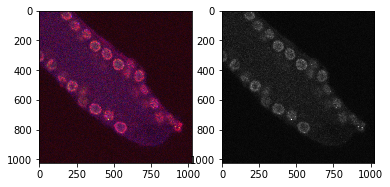

In [6]:
# Plot a test image from experimental
fig, ax = plt.subplots(1,2)

# Normal image
image = exp_dict.get(1)
ax[0].imshow(image)

# Convert image to grayscale
image_gray = rgb2gray(image)
ax[1].imshow(image_gray,cmap="gray")

Identifying potential nuclei in sample image...


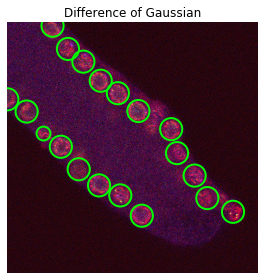

In [7]:
# Identifying potential nuclei using Difference of Gaussians (it's fast)
print('Identifying potential nuclei in sample image...')

# Difference of gaussians, compute radii in the 3rd column
blobs_dog = blob_dog(image_gray, min_sigma = 20, max_sigma=50, threshold=.3)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for blobs in blobs_dog:
    y, x, r = blobs
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
# Choose five nuclei at random
print('Choosing five nuclei at random that are big enough...')
nuclei = []
for counter, item in enumerate(blobs_dog):
#     contender = blobs_dog[np.random.randint(0, len(blobs_dog))]       # Uncomment this and comment next to choose at random
    contender = item
    if len(nuclei) < 5 and contender[2] > 40:
        nuclei.append(contender)
        
# Convert your nuclei's info into a tuple for faster processing
nuclei = tuple(nuclei)
print(f'Successfully chose {len(nuclei)} nuclei.')

Choosing five nuclei at random that are big enough...
Successfully chose 5 nuclei.


Plotting chosen nuclei...

If you see less than five nuclei on the picture please resample nuclei.



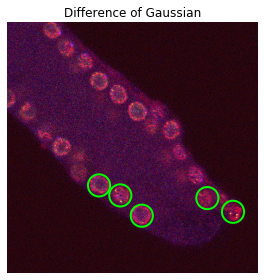

In [9]:
# Plotting the five nuclei we randomly selected
print('Plotting chosen nuclei...\n')
print('If you see less than five nuclei on the picture please resample nuclei.\n')

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for nucleus in nuclei:
    y, x, r = nucleus
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()



# Example analysis of puncta on a single image. 
# Skip to the bottom to see bulk identification.

### Creating a mask to remove everything from the imaged except our nuclei

In [10]:
# Preparing a circle mask for each sampled nuclei and storing in a dictionary
circle_masks = {}
for counter, nucleus in enumerate(nuclei):
    circle_masks.setdefault(counter, circle(nucleus[0], nucleus[1], nucleus[2]))

In [11]:
mask = np.zeros(image.shape[0:2],dtype=np.bool)
for counter, nucleus in enumerate(nuclei):
    mask[circle_masks.get(counter)] = True

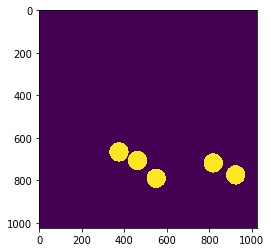

In [12]:
# Plotting mask by itself to check if it's working
plt.imshow(mask)

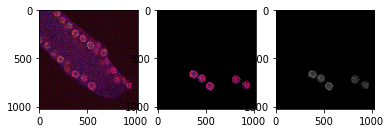

In [13]:
# Masking the image - make everything outside of our nuclei black
# Inverse application of the mask by using ~mask (it's like ~True = False)

fig, ax = plt.subplots(1,3)
ax[0].imshow(image)
image[~mask,:] = 0
ax[1].imshow(image)

# Convert image to grayscale
image_gray = rgb2gray(image)
ax[2].imshow(image_gray,cmap="gray")

### Finding the puncta in our isolated nuclei using difference in Gaussians

Identifying potential puncta in sample image...


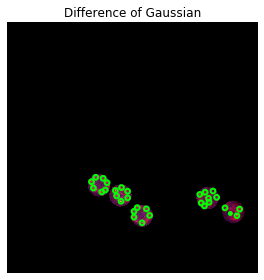

In [14]:
print('Identifying potential puncta in sample image...')


# Difference of gaussians, compute radii in the 3rd column
blobs_dog = blob_dog(image_gray, min_sigma=0.1, max_sigma=10, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for blobs in blobs_dog:
    y, x, r = blobs
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
# Save location of your test puncta
puncta_location = blobs_dog

### Get the color of detected puncta and eliminate those that are not green enough

In [16]:
# Get the color of each pucta (from Mike's 01_counting_colonies_key)
def get_puncta_color(image,puncta):

    # Grab circle center (a,b) and radius (r)
    a, b, r = puncta
        
    # Draw circle for blob
    circle_mask = circle(a,b,r)
    
    # Create mask of False over whole image
    mask = np.zeros(image.shape[0:2],dtype=np.bool)
    mask[circle_mask] = True
    
    red = np.average(image[mask,0])
    green = np.average(image[mask,1])
    blue = np.average(image[mask,2])
    
    return red, green, blue

In [17]:
# Get the colors of all puncta
print('Obtaining the colors of all potential puncta...')
puncta_colors = np.zeros((len(puncta_location),3))
for counter, puncta in enumerate(puncta_location):
    puncta_colors[counter,:] = get_puncta_color(image,puncta)

Obtaining the colors of all potential puncta...


In [18]:
# Eliminate any pucta with a green value of less than a 100
print('Eliminating puncta that are not green enough...')
green_puncta = []
not_green = 0
green = 0
for counter, puncta in enumerate(puncta_location):
    if puncta_colors[counter][2] < 100:
        not_green += 1
    else:
        green += 1
        green_puncta.append(puncta)

print(f'Found {green} puncta that are green and {not_green} false positives.')

Eliminating puncta that are not green enough...
Found 2 puncta that are green and 29 false positives.


In [19]:
# Sorting the puncta by nuclei
sorted_puncta = {}
for counter, nucleus in enumerate(nuclei):
    center_x = nucleus[0]
    center_y = nucleus[1]
    radius = nucleus[2]
    contained_puncta = []
    for _, puncta in enumerate(green_puncta):
        x = puncta[0]
        y = puncta[1]      
        if (x-center_x)**2 + (y-center_y)**2 <= radius**2:
            contained_puncta.append(puncta)
#             print(f'puncta {_} sorted into nuclei {counter+1}')    # Uncomment to see in real time where the puncta are sorted
    sorted_puncta.setdefault(counter, contained_puncta)

    
# Verify that all puncta were sorted
verification = np.empty(len(nuclei))
for counter, nucleus in enumerate(nuclei):
    verification[counter] = len(sorted_puncta[counter])
    
if np.sum(verification) == len(green_puncta):
    print('All puncta were successfully sorted.')
else:
    print('At least one of the puncta was not properly sorted.')

All puncta were successfully sorted.


In [20]:
for counter, nucleus in enumerate(nuclei):
    print(f'In this single image analysis, nucleus {counter+1} contains {len(sorted_puncta[counter])} puncta')

In this single image analysis, nucleus 1 contains 0 puncta
In this single image analysis, nucleus 2 contains 0 puncta
In this single image analysis, nucleus 3 contains 0 puncta
In this single image analysis, nucleus 4 contains 1 puncta
In this single image analysis, nucleus 5 contains 1 puncta


# [Experimental] Applying puncta analysis to all experimental images using a loop

In [21]:
# A loop to iterate through all experimental images & collect ALL the locations of puncta across all images
# This takes a long time to run, use "if counter < 10:" at the very beginning of the loop to test with only 10 images

green_puncta = []

for counter, image in enumerate(experimental):
#     if counter < 10                             # Uncomment this part to test with only 10 images
    # Calling images from dict
    image = exp_dict.get(counter)
    image_gray = rgb2gray(image)
    
    # Turn everything outside of our nuclei black
    image[~mask,:] = 0
    
    # Getting gray image
    image_gray = rgb2gray(image)

    # Using blob dogs to detect potential puncta
    blobs_dog = blob_dog(image_gray, min_sigma=0.1, max_sigma=10, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
    puncta_location = blobs_dog
    
    # Get the colors of all detected puncta
    puncta_colors = np.zeros((len(puncta_location),3))
    for counter, puncta in enumerate(puncta_location):
        puncta_colors[counter,:] = get_puncta_color(image,puncta)
        
    # Collect all green puncta (filtering by color green)
    for counter, puncta in enumerate(puncta_location):
        if puncta_colors[counter][2] < 100:
            pass
        else:
            green_puncta.append(puncta)

print(f'Found {len(green_puncta)} green puncta in all combined control images')

Found 425 green puncta in all combined control images


In [22]:
# Eliminating green puncta that are repeated in our global list of green puncta
# Using the square of the difference. This means that as long as the x coordinate is at least 20 units away
# and the y coordinate is at least 20 units away from the next point, then it is considered to be a new puncta

non_repeated_green_puncta = []
for counter, gpuncta in enumerate(green_puncta):
    if counter < len(green_puncta)-1:
        if (green_puncta[counter+1][0] - green_puncta[counter][0])**2 < 20**2 and (green_puncta[counter+1][1] - green_puncta[counter][1])**2 < 20**2:
            non_repeated_green_puncta.append(gpuncta)
        else:
            pass

print(f'The number of non-repeated green puncta in the experimental set is {len(non_repeated_green_puncta)}, chosen from {len(green_puncta)} total points.')

The number of non-repeated green puncta in the experimental set is 24, chosen from 425 total points.


In [23]:
# Sorting ALL non-repeated puncta by nuclei

sorted_experimental_puncta = {}
for counter, nucleus in enumerate(nuclei):
    center_x = nucleus[0]
    center_y = nucleus[1]
    radius = nucleus[2]
    contained_puncta = []
    for _, puncta in enumerate(non_repeated_green_puncta):
        x = puncta[0]
        y = puncta[1]      
        if (x-center_x)**2 + (y-center_y)**2 <= radius**2:
            contained_puncta.append(puncta)
    sorted_experimental_puncta.setdefault(counter, contained_puncta)
    
# Verify that all puncta were sorted
verification = np.empty(len(nuclei))
for counter, nucleus in enumerate(nuclei):
    verification[counter] = len(sorted_experimental_puncta[counter])
    
if np.sum(verification) == len(non_repeated_green_puncta):
    print(f'All {len(non_repeated_green_puncta)} puncta were successfully sorted.')
else:
    print('At least one of the puncta was not properly sorted.')

All 24 puncta were successfully sorted.


$\implies$ Now all the info you need about the experimental images is stored in `sorted_control_puncta`

# [Control] Applying puncta analysis to all control images using a loop

First, choose the five nuclei to use for the control images

Identifying potential nuclei in sample image...


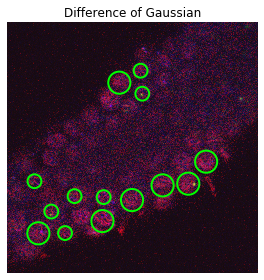

In [24]:
# Convert image to grayscale
image = control_dict.get(1)
image_gray = rgb2gray(image)

# Identifying potential nuclei using Difference of Gaussians (it's fast)
print('Identifying potential nuclei in sample image...')

# Difference of gaussians, compute radii in the 3rd column
blobs_dog = blob_dog(image_gray, min_sigma = 20, max_sigma=50, threshold=.3, overlap=0.01)  # Reduce overlap to separate overlapping blobs
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for blobs in blobs_dog:
    y, x, r = blobs
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [25]:
# Choose first five nuclei (or choose five at random)
print('Choosing five nuclei at random that are big enough...')
nuclei = []
for counter, item in enumerate(blobs_dog):
#     contender = blobs_dog[np.random.randint(0, len(blobs_dog))]       # Uncomment this and comment next to choose at random
    contender = item
    if len(nuclei) < 5 and contender[2] > 40:
        nuclei.append(contender)
        
# Convert your nuclei's info into a tuple for faster processing
nuclei = tuple(nuclei)
print(f'Successfully chose {len(nuclei)} nuclei.')

Choosing five nuclei at random that are big enough...
Successfully chose 5 nuclei.


Plotting chosen nuclei...

If you see less than five nuclei on the picture please resample nuclei.



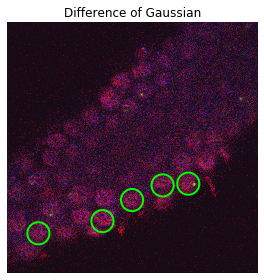

In [26]:
# Plotting the five nuclei we randomly selected
print('Plotting chosen nuclei...\n')
print('If you see less than five nuclei on the picture please resample nuclei.\n')

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for nucleus in nuclei:
    y, x, r = nucleus
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()

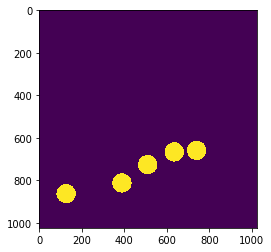

In [27]:
# Preparing a circle mask for each sampled nuclei and storing in a dictionary
circle_masks = {}
for counter, nucleus in enumerate(nuclei):
    circle_masks.setdefault(counter, circle(nucleus[0], nucleus[1], nucleus[2]))

# Plot mask to double check it looks good
mask = np.zeros(image.shape[0:2],dtype=np.bool)
for counter, nucleus in enumerate(nuclei):
    mask[circle_masks.get(counter)] = True
    
plt.imshow(mask)

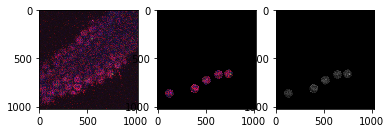

In [28]:
# Masking the image - make everything outside of our nuclei black
# Inverse application of the mask by using ~mask (it's like ~True = False)

fig, ax = plt.subplots(1,3)
ax[0].imshow(image)
image[~mask,:] = 0
ax[1].imshow(image)

# Gray image for analysis
image_gray = rgb2gray(image)
ax[2].imshow(image_gray,cmap="gray")

Identifying potential puncta in sample image...


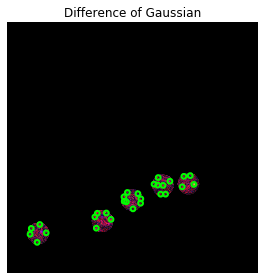

In [29]:
print('Identifying potential puncta in sample image...')


# Difference of gaussians, compute radii in the 3rd column
blobs_dog = blob_dog(image_gray, min_sigma=0.1, max_sigma=10, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

fig, axes = plt.subplots(sharex=True, sharey=True)

axes.set_title('Difference of Gaussian')
axes.imshow(image)
for blobs in blobs_dog:
    y, x, r = blobs
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    axes.add_patch(c)
axes.set_axis_off()

plt.tight_layout()
plt.show()

In [30]:
# A loop to iterate through all control images & collect ALL the locations of puncta across all images

green_puncta = []

for counter, image in enumerate(control):
    #Import image
    image = control_dict.get(counter)
    image_gray = rgb2gray(image)
    
    # Turn everything outside of our nuclei black
    image[~mask,:] = 0
    
    #Getting gray image
    image_gray = rgb2gray(image)

    # Using blob dogs to detect potential puncta
    blobs_dog = blob_dog(image_gray, min_sigma=0.1, max_sigma=10, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
    puncta_location = blobs_dog
    
    # Get the colors of all detected puncta
    puncta_colors = np.zeros((len(puncta_location),3))
    for counter, puncta in enumerate(puncta_location):
        puncta_colors[counter,:] = get_puncta_color(image,puncta)
        
    # Collect all green puncta (filtering by color green)
    for counter, puncta in enumerate(puncta_location):
        if puncta_colors[counter][2] < 100:
            pass
        else:
            green_puncta.append(puncta)
            
print(f'Found {len(green_puncta)} green puncta in all combined control images')

C:\Users\Luis\Miniconda3\envs\ide\lib\site-packages\skimage\feature\blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
C:\Users\Luis\Miniconda3\envs\ide\lib\site-packages\skimage\feature\blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
C:\Users\Luis\Miniconda3\envs\ide\lib\site-packages\skimage\feature\blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
C:\Users\Luis\Miniconda3\envs\ide\lib\site-packages\skimage\feature\blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


Found 4 green puncta in all combined control images


In [31]:
# Eliminating green puncta that are repeated in our global list of green puncta
# Using the square of the difference. This means that as long as the x coordinate is at least 20 units away
# and the y coordinate is at least 20 units away from the next point, then it is considered to be a new puncta

non_repeated_control_green_puncta = []
for counter, gpuncta in enumerate(green_puncta):
    if counter < len(green_puncta)-1:
        if (green_puncta[counter+1][0] - green_puncta[counter][0])**2 < 20**2 and (green_puncta[counter+1][1] - green_puncta[counter][1])**2 < 20**2:
            non_repeated_control_green_puncta.append(gpuncta)
        else:
            pass

print(f'The number of non-repeated green puncta in the control set is {len(non_repeated_control_green_puncta)}, chosen from {len(green_puncta)} total points.')

The number of non-repeated green puncta in the control set is 2, chosen from 4 total points.


In [32]:
# Sorting ALL non-repeated puncta by nuclei

sorted_control_puncta = {}
for counter, nucleus in enumerate(nuclei):
    center_x = nucleus[0]
    center_y = nucleus[1]
    radius = nucleus[2]
    contained_puncta = []
    for _, puncta in enumerate(non_repeated_control_green_puncta):
        x = puncta[0]
        y = puncta[1]      
        if (x-center_x)**2 + (y-center_y)**2 <= radius**2:
            contained_puncta.append(puncta)
    sorted_control_puncta.setdefault(counter, contained_puncta)
    
# Verify that all puncta were sorted
verification = np.empty(len(nuclei))
for counter, nucleus in enumerate(nuclei):
    verification[counter] = len(sorted_control_puncta[counter])
    
if np.sum(verification) == len(non_repeated_control_green_puncta):
    print(f'All {len(non_repeated_control_green_puncta)} puncta were successfully sorted.')
else:
    print('At least one of the puncta was not properly sorted.')

All 2 puncta were successfully sorted.


# Running statistics on the stuff

In [33]:
# Getting the number of observations per nuclei

puncta_per_nucleus_experimental = [len(nucleus) for nucleus in sorted_experimental_puncta.values()]
print(puncta_per_nucleus_experimental)

puncta_per_nucleus_control = [len(nucleus) for nucleus in sorted_control_puncta.values()]
print(puncta_per_nucleus_control)

[6, 0, 12, 2, 4]
[0, 0, 0, 2, 0]


In [34]:
# Mean and std deviation of puncta found in nuclei

experimental_mean = np.mean(puncta_per_nucleus_experimental)
experimental_std = np.std(puncta_per_nucleus_experimental)

control_mean = np.mean(puncta_per_nucleus_control)
control_std = np.std(puncta_per_nucleus_control)

print(f'The puncta found in the experimental worm were distributed as follows: \n'
      f' Mean = {experimental_mean:34.2f} \n'
      f' Standard deviation = {experimental_std:20.2f}\n')

print(f'The puncta found in the experimental worm were distributed as follows: \n'
      f' Mean = {control_mean:34.2f} \n'
      f' Standard deviation = {control_std:20.2f}\n')

The puncta found in the experimental worm were distributed as follows: 
 Mean =                               4.80 
 Standard deviation =                 4.12

The puncta found in the experimental worm were distributed as follows: 
 Mean =                               0.40 
 Standard deviation =                 0.80



In [35]:
from scipy import stats

In [36]:
"""
from floating help:

Signature: stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, optional
    Axis along which to compute test. If None, compute over the whole
    arrays, `a`, and `b`.
equal_var : bool, optional
    If True (default), perform a standard independent 2 sample test
    that assumes equal population variances [1]_.
    If False, perform Welch's t-test, which does not assume equal
    population variance [2]_.

"""
stats.ttest_ind(puncta_per_nucleus_experimental, puncta_per_nucleus_control)

Ttest_indResult(statistic=2.097617696340303, pvalue=0.06919345365428058)

Since $p > 0.05$ we can't reject the null hypothesis, $\implies$ the differences between the number of green puncta found in the control and experimental data sets is not statistically different from each other.